# Twitter

##  `[25 pts]` Punto 1: Extraer Tuits
Extraer mínimo 100 tuits de Twitter usando la API

(Si exponen sus claves, les haré maldades 😈)

❌🎃❌ ¡No Halloween!

- librerias

In [142]:
import numpy as np
import pandas as pd
import tweepy

import re
import regex
import emoji

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

from collections import Counter

import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import PIL.Image
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True)

In [3]:
# autenticacion

auth = tweepy.OAuthHandler(API_key, API_secret_key)

auth.set_access_token(Access_token, Access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [63]:
# recolectar los primeros 10 datos

def CrearTweets(query, k):
    '''
    Creación de la base de tweets con los primeros k registros.
    Parámetros:
    - query: string de la consulta
    - k: número de registros
    '''
    tweets = tweepy.Cursor(api.search,
                           q=query,
                           lang='es',
                           #geocode=f"4.649178,-74.062827,60km", #Bogotá
                           result_type='mixed',
                           tweet_mode='extended',
                           include_rts=False).items(k)
    
    t = []
    for tweet in tweets:
        temp = []
        temp.append(tweet.id)
        temp.append(tweet.created_at)
        temp.append(tweet.user.screen_name)
        temp.append(tweet.full_text)
        temp.append(tweet.user.location)
        temp.append(f"https://twitter.com/i/web/status/{tweet.id}")
        t.append(temp)

    data = pd.DataFrame(data=t, columns=['id','fecha_pub','usuario','tweet','user_location','link'])
    return data

In [64]:
print(CrearTweets.__doc__)


    Creación de la base de tweets con los primeros k registros.
    Parámetros:
    - query: string de la consulta
    - k: número de registros
    


In [58]:
query='viernes 13 -RT'

data = CrearTweets(query,10)
data.head()

,id,fecha_pub,usuario,tweet,user_location,link
0,1326928429091065859,2020-11-12 16:42:45,VTVcanal8,"#EnVideo📹| Desde este viernes 13 de noviembre,...",Venezuela,https://twitter.com/i/web/status/1326928429091...
1,1326848774510170114,2020-11-12 11:26:14,KiddKeo95Flames,"y mañana es viernes 13 hay q hacer algo, Llama...",ROCKPORT,https://twitter.com/i/web/status/1326848774510...
2,1326928773682524160,2020-11-12 16:44:07,QuinteroCalle,"Con el Gobierno Nacional, los alcaldes del @Ar...","Medellín, Colombia",https://twitter.com/i/web/status/1326928773682...
3,1327096677384204291,2020-11-13 03:51:18,DiegoUsui,¿Alguien para dedicarle Viernes 13?\n\nUrge pa...,"Pachuca de Soto, Hidalgo",https://twitter.com/i/web/status/1327096677384...
4,1327096674829934592,2020-11-13 03:51:18,axterix1366,El Gran Maestro jacques de MOLAY Gran Maestre ...,Mex D F,https://twitter.com/i/web/status/1327096674829...


In [70]:
def ActualizarTweets(query, k, data):
    '''
    Actualizar base de tweets con k registros.
    Parámetros:
    - query: string de la consulta
    - k: número de registros
    - data: dataframe para actualizar
    '''
    tweets = tweepy.Cursor(api.search,
                           q=query,
                           lang='es',
                           #geocode=f"4.649178,-74.062827,60km", #Bogotá
                           result_type='mixed',
                           tweet_mode='extended',
                           include_rts=False,
                           since_id=data.id.max()).items(k)
    
    t = []
    for tweet in tweets:
        temp = []
        temp.append(tweet.id)
        temp.append(tweet.created_at)
        temp.append(tweet.user.screen_name)
        temp.append(tweet.full_text)
        temp.append(tweet.user.location)
        temp.append(f"https://twitter.com/i/web/status/{tweet.id}")
        t.append(temp)

    data2 = pd.DataFrame(data=t, columns=['id','fecha_pub','usuario','tweet','user_location','link'])
    data = pd.concat([data, data2], axis=0)
    return data

### DataFrame con los tweets

In [71]:
data2 = ActualizarTweets(query, 190, data)

In [72]:
data2.shape

(200, 6)

### Pre procesamiento

In [74]:
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweet']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
             
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag,"")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention,"")
        
    return text, links, hashtags, mentions

In [75]:
data2[['tweet_clean','links','hashtags','mentions']] = data2.apply(text_clean, axis=1, result_type='expand')
data2.head()

,id,fecha_pub,usuario,tweet,user_location,link,tweet_clean,links,hashtags,mentions
0,1326928429091065859,2020-11-12 16:42:45,VTVcanal8,"#EnVideo📹| Desde este viernes 13 de noviembre,...",Venezuela,https://twitter.com/i/web/status/1326928429091...,"Desde este viernes 13 de noviembre, inicia d...",[https://t.co/xOEZfR4e0k],"[#EnVideo📹|, #LeerDesbloquea]",[@ve_cne]
1,1326848774510170114,2020-11-12 11:26:14,KiddKeo95Flames,"y mañana es viernes 13 hay q hacer algo, Llama...",ROCKPORT,https://twitter.com/i/web/status/1326848774510...,"y mañana es viernes 13 hay q hacer algo, Llama...",[],[],[]
2,1326928773682524160,2020-11-12 16:44:07,QuinteroCalle,"Con el Gobierno Nacional, los alcaldes del @Ar...","Medellín, Colombia",https://twitter.com/i/web/status/1326928773682...,"Con el Gobierno Nacional, los alcaldes del y ...",[],[],"[@Areametropol, @anibalgaviria]"
3,1327096677384204291,2020-11-13 03:51:18,DiegoUsui,¿Alguien para dedicarle Viernes 13?\n\nUrge pa...,"Pachuca de Soto, Hidalgo",https://twitter.com/i/web/status/1327096677384...,¿Alguien para dedicarle Viernes 13?\n\nUrge pa...,[],[],[]
4,1327096674829934592,2020-11-13 03:51:18,axterix1366,El Gran Maestro jacques de MOLAY Gran Maestre ...,Mex D F,https://twitter.com/i/web/status/1327096674829...,El Gran Maestro jacques de MOLAY Gran Maestre ...,[https://t.co/VFTvEtC7dm],[],[]


In [77]:
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for letra in data:
        if any(char in emoji.UNICODE_EMOJI for char in letra):
            emoji_list.append(letra)

    return emoji_list

In [163]:
data2['emojis'] = data2['tweet_clean'].apply(lambda text: get_emojis(text))
data2.head()

,id,fecha_pub,usuario,tweet,user_location,link,tweet_clean,links,hashtags,mentions,emojis,pre_procesado,Date
0,1326928429091065859,2020-11-12 16:42:45,VTVcanal8,"#EnVideo📹| Desde este viernes 13 de noviembre,...",Venezuela,https://twitter.com/i/web/status/1326928429091...,"Desde este viernes 13 de noviembre, inicia d...",[https://t.co/xOEZfR4e0k],"[#EnVideo📹|, #LeerDesbloquea]",[@ve_cne],[],noviembre inicia despliegue maquinas votacion ...,2020-11-12
1,1326848774510170114,2020-11-12 11:26:14,KiddKeo95Flames,"y mañana es viernes 13 hay q hacer algo, Llama...",ROCKPORT,https://twitter.com/i/web/status/1326848774510...,"y mañana es viernes 13 hay q hacer algo, Llama...",[],[],[],[],q hacer llama jason vamonos d party,2020-11-12
2,1326928773682524160,2020-11-12 16:44:07,QuinteroCalle,"Con el Gobierno Nacional, los alcaldes del @Ar...","Medellín, Colombia",https://twitter.com/i/web/status/1326928773682...,"Con el Gobierno Nacional, los alcaldes del y ...",[],[],"[@Areametropol, @anibalgaviria]",[],gobierno nacional alcaldes gobernador decidimo...,2020-11-12
3,1327096677384204291,2020-11-13 03:51:18,DiegoUsui,¿Alguien para dedicarle Viernes 13?\n\nUrge pa...,"Pachuca de Soto, Hidalgo",https://twitter.com/i/web/status/1327096677384...,¿Alguien para dedicarle Viernes 13?\n\nUrge pa...,[],[],[],[🥴],alguien dedicarle urge,2020-11-13
4,1327096674829934592,2020-11-13 03:51:18,axterix1366,El Gran Maestro jacques de MOLAY Gran Maestre ...,Mex D F,https://twitter.com/i/web/status/1327096674829...,El Gran Maestro jacques de MOLAY Gran Maestre ...,[https://t.co/VFTvEtC7dm],[],[],[],gran maestro jacques molay gran maestre pauper...,2020-11-13


In [135]:
stopwords_sp = stopwords.words('spanish')
stopwords_sp = stopwords_sp + ['viernes','dia','mañana','hoy']

def quitar_tildes(s):
    tildes = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for origen, destino in tildes:
        s = s.replace(origen, destino)
    return s

def pre_procesado(texto):
    texto = texto.lower() # minúsculas
    texto = re.sub(r"[\W\d_]+", " ",texto) # remove caract, números
    #texto = re.sub(r"[\W]+", " ",texto) # remove caract
    texto = quitar_tildes(texto) # remove tildes
    texto = texto.split() # tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp] # stopwords
    texto = " ".join(texto)
    return texto

In [138]:
tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado, ngram_range=(1,2), max_features=100)
tfidf = tfidf_vect.fit_transform(data2.tweet_clean.values)

In [136]:
data2['pre_procesado'] = data2['tweet_clean'].apply(lambda text: pre_procesado(text))
data2.head()

,id,fecha_pub,usuario,tweet,user_location,link,tweet_clean,links,hashtags,mentions,emojis,pre_procesado
0,1326928429091065859,2020-11-12 16:42:45,VTVcanal8,"#EnVideo📹| Desde este viernes 13 de noviembre,...",Venezuela,https://twitter.com/i/web/status/1326928429091...,"Desde este viernes 13 de noviembre, inicia d...",[https://t.co/xOEZfR4e0k],"[#EnVideo📹|, #LeerDesbloquea]",[@ve_cne],[],noviembre inicia despliegue maquinas votacion ...
1,1326848774510170114,2020-11-12 11:26:14,KiddKeo95Flames,"y mañana es viernes 13 hay q hacer algo, Llama...",ROCKPORT,https://twitter.com/i/web/status/1326848774510...,"y mañana es viernes 13 hay q hacer algo, Llama...",[],[],[],[],q hacer llama jason vamonos d party
2,1326928773682524160,2020-11-12 16:44:07,QuinteroCalle,"Con el Gobierno Nacional, los alcaldes del @Ar...","Medellín, Colombia",https://twitter.com/i/web/status/1326928773682...,"Con el Gobierno Nacional, los alcaldes del y ...",[],[],"[@Areametropol, @anibalgaviria]",[],gobierno nacional alcaldes gobernador decidimo...
3,1327096677384204291,2020-11-13 03:51:18,DiegoUsui,¿Alguien para dedicarle Viernes 13?\n\nUrge pa...,"Pachuca de Soto, Hidalgo",https://twitter.com/i/web/status/1327096677384...,¿Alguien para dedicarle Viernes 13?\n\nUrge pa...,[],[],[],[🥴],alguien dedicarle urge
4,1327096674829934592,2020-11-13 03:51:18,axterix1366,El Gran Maestro jacques de MOLAY Gran Maestre ...,Mex D F,https://twitter.com/i/web/status/1327096674829...,El Gran Maestro jacques de MOLAY Gran Maestre ...,[https://t.co/VFTvEtC7dm],[],[],[],gran maestro jacques molay gran maestre pauper...


##  `[25 pts]` Punto 2: Hacer una visualización sobre esos tuits

❌🎃❌ ¡No Halloween!

### Nube de palabras

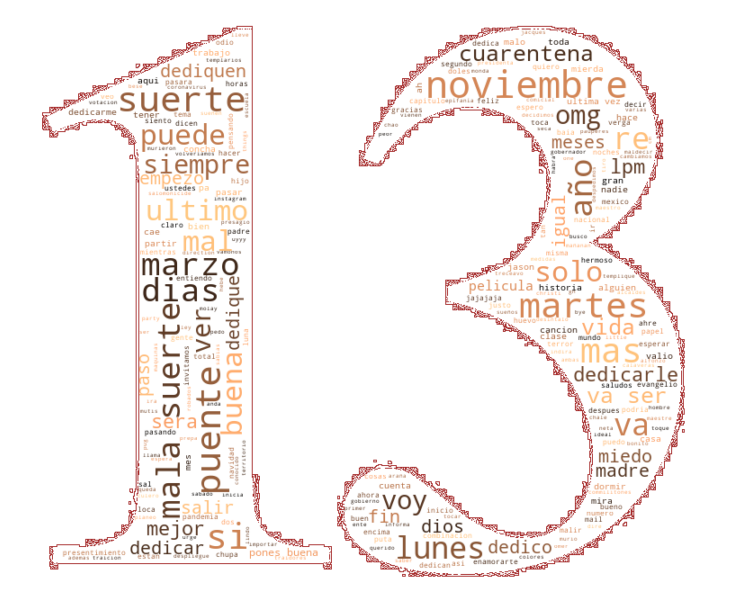

In [137]:
trece = PIL.Image.open("13.jpg")
#display(trece)

trece_mask = np.array(trece)
palabras = data2.pre_procesado.str.cat(sep=" ")
 
wordcloud = WordCloud(width=800, height=400,
                      max_font_size=150, max_words=250,
                      background_color='white', colormap='copper_r',
                      stopwords=None, random_state=137,
                      mask=trece_mask, contour_width=0.5, contour_color='brown').generate(palabras)
 
wordcloud.to_file("trece_wordcloud.png")
 
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [140]:
temp_emojis = pd.DataFrame(list(zip(Counter(sum(data2.emojis.values,[])).keys(),Counter(sum(data2.emojis.values,[])).values())))
temp_emojis.columns = ['emoji', 'cnt']
temp_emojis.sort_values('cnt', ascending=False, inplace=True)
temp_emojis.head()

,emoji,cnt
2,😔,9
0,🥴,5
12,✨,4
31,🍀,4
56,😭,4


In [143]:
trace = go.Bar(x=temp_emojis.emoji.values[:15],
               y=temp_emojis.cnt.values[:15])
 
layout = go.Layout(title='Emojis más usados')
 
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [253]:
data2['Date']= pd.to_datetime(data2['fecha_pub']).dt.strftime('%Y-%m-%d')

fig = px.bar(temp_emojis, x=temp_emojis.emoji.values, y='cnt', color='emoji',
  animation_frame=temp_emojis.emoji.values, animation_group='cnt')
fig.show()